In [1]:
#from langchain.llms import Ollama
from langchain.chains import LLMChain
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.types import interrupt
from langgraph.checkpoint.memory import MemorySaver
from operator import add
from langgraph.types import Command

In [2]:
#llm = OllamaLLM(base_urk="http://localhost:11434", model = "deepseek-r1:32b", streaming=True)

In [3]:
from langchain_ollama import OllamaLLM

llm1 = OllamaLLM(base_urk="http://localhost:11434", model = "llama3.2:1b", streaming=True)

In [4]:
class State(TypedDict):
    bugID: int
    bugAnalized: str
    bugDescription: str
    userData: str
    historicalData: str
    waitingState: int
    reproduceSuggestion: str
    testResult: str
    reviewResult: str
    failReproduce: str
    userReview: str


In [5]:
def printSteam(llm, prompt="Hello"):
    output = ""
    for chunk in llm.stream(prompt):
        print(chunk, end="", flush=True)
        output += chunk
    #print(output)
    return output
    
# a = printSteam(llm, "Hello")
# print(a)

# b = printSteam(llm1, "Hello")
# print(b)

In [6]:
def getRelatedBugs(description):
    related =  """Here is the list of related bugs:
    #12245 TimerCell is not working
    Steps to reproduce:
    1. Create a TimerCell
    2. Set the time to 1000 seconds
    3. Start the TimerCell

    #42345 TimerCell not fired
    Steps to reproduce:
    1. Create a TimerCell
    2. Set the time to 0 seconds
    3. Start the TimerCell

    #23145 Valgrind reports memory leaks with timer_cell
    Steps to reproduce:
    1. Create a TimerCell
    2. Set the time to 10 seconds
    3. Start the TimerCell
    """
    return related

In [7]:
def checkIDValid(bugID):
    if bugID < 100000:
        return True
    return False

def checkInfor(state: State):
    if "NOK" in state["reproduceSuggestion"]:
        print("\checkInfor NOK\n")
        return "MISSING_INFO"
    print("\nCheckPoint OK\n")
    return "OK"

def checkStopPoint(state: State):
    if "NOK" in state["reviewResult"]:
        print("\nCheckPoint NOK\n")
        return "NOK"
    print("\nCheckPoint OK\n")
    return "OK"

def checkUserReview(state: State):
    if "NOK" in state["userReview"]:
        print("\nUser review NOK\n")
        return "NOK"
    print("\nUser review OK\n")
    return "OK"



<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_6912/3851216829.py:8: SyntaxWarning: invalid escape sequence '\c'
  print("\checkInfor NOK\n")


In [8]:
def userProvider(state: State):
    print("\n*********************userProvider**************************\n")
    result = interrupt(
        # Interrupt information to surface to the client.
        # Can be any JSON serializable value.
        {
            "task": "Review the output from the LLM and make any necessary edits.",
            "bugDescription": state["bugDescription"]
        }
    )
    print(result)
    #print(result["edited_text"])
    # Update the state with the edited text
    return {
        "userData": result 
    }

In [9]:
def User(state: State):
    print("\n*********************user**************************\n")
    result = interrupt(
        # Interrupt information to surface to the client.
        # Can be any JSON serializable value.
        {
            "task": "Review the output from the LLM and make any necessary edits.",
            "bugDescription": state["bugDescription"]
        }
    )
    print(result)
    #print(result["edited_text"])
    # Update the state with the edited text
    return {
        "userReview": result 
    }

In [10]:
def AnalyserAgent(state: State):
    print("\n*********************AnalyserAgent**************************\n")
    #TODO: Get the bug information from the bug tracker with the bugID
    #Step:
    #1. Ask user if they want to input extra information to agent => If yes, store them in userData State
    #2. Get all raw data from redmine, then take the needed information to identify what is the problem  => Store to bugAnalized
    #3. Store the description to bugDescription
    information = "Memory keep inceased after timer_cell is fired"

    msg = printSteam(llm1, f"Analyse the bug with the following information: {information}")
    return {"bugAnalized": msg, "bugDescription": information}

In [11]:
def RetrieverAgent(state: State):
    print("\n*********************RetrieverAgent**************************\n")
    bugDescription = state["bugDescription"]
    print("INPUT: \n", bugDescription)

    #TODO: Get the related historical data from vectorDB with the bug description
    #need input from the AnalyserAgent

    #Call the retrieve function from the vectorDB
    msg = getRelatedBugs(bugDescription)
    print("OUTPUT:\n", msg)
    return {"historicalData": msg}

In [12]:
def waiting(state: State):
    #TODO: Get the related code changes
    return {"waitingState": 1}

In [13]:
def DecisionAgent(state: State, retry=0):
    print("\n*********************DecisionAgent**************************\n")
    
    #The brain of agentic reproducer
    #Take input from the bugAnalyser and RetrieverAgent then suggest the reproduction steps
    req_info = ["bugDescription", "historicalData"]

    for req in req_info:
        if req not in state:
            print("Missing INPUT!!!\n")
            return {"reproduceSuggestion": "NOK"}

    bugDescription = state["bugDescription"]
    historicalData = state["historicalData"]
    if retry:
        failReproduce = state["failReproduce"]

    print("INPUT:\n", bugDescription, historicalData)
    #historicalData is a few shot example for LLM to predict the reproduce steps
    #historicalData format: "Problem: Reproduce steps"
    intruction = f"You are a TesterAgent and you need to reproduce the problem with the following information:\n"

    #few shot prompt
    prompt = f"Exmaple: {historicalData}\n EndofExample. \nStep to reproduce the problem with the following information: {bugDescription}"

    if retry:
        prompt = f"Reproduce Exmaple: {historicalData}\nEndofExample\nAttempting to reproduce the failure:{failReproduce}\nEnd of trying\nWith all above information give the step to reproduce the problem with the following information: {bugDescription}"

    msg = printSteam(llm1, prompt)

    print(f"OUTPUT:\n{msg} ENDOF DecisionAgent \n")
    return {"reproduceSuggestion": msg}


In [14]:
# from langchain_core.tools import tool
# from langgraph.graph import MessagesState
# from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage

# llm2 = OllamaLLM(base_urk="http://localhost:11434", model = "llama3.2:3b", streaming=True)

# # Define tools
# @tool
# def multiply(a: int, b: int) -> int:
#     """Multiply a and b.

#     Args:
#         a: first int
#         b: second int
#     """
#     return a * b

# # Augment the LLM with tools
# tools = [multiply]
# tools_by_name = {tool.name: tool for tool in tools}
# llm_with_tools = llm2.bind_tools(tools)

# def llm_call(state: MessagesState):
#     """LLM decides whether to call a tool or not"""
#     return {
#         "messages": [
#             llm_with_tools.invoke(
#                 [
#                     SystemMessage(
#                         content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
#                     )
#                 ]
#                 + state["messages"]
#             )
#         ]
#     }

In [15]:
def TesterAgent(state: State):
    print("\n*********************TesterAgent**************************\n")
    #TODO: Trigger function call to reproduce the problem
    if "reproduceSuggestion" not in state:

        print("OUTPUT:\n This test is NOK END of TesterAgent\n")
        return {"testResult": "The test is NOK"}

    reproduceSuggestion = state["reproduceSuggestion"]
    print("INPUT:\n", reproduceSuggestion)

    if "testResult" in state:
        testResult = "The test is OK"
    else:
        testResult = "The test is NOK"
    print(f"OUTPUT:\n{testResult} ENDOF TesterAgent\n")
    return {"testResult": testResult}

In [ ]:
def ReviewerAgent(state: State):
    print("\n*********************ReviewerAgent**************************\n")
    testResult = state["testResult"]
    print("INPUT: \n", testResult)

    msg = printSteam(llm1, f"Review the test result is OK or NOK, only print answer: {testResult}")
    print(f"OUTPUT:\n{msg} ENDOF ReviewerAgent\n")
    return {"reviewResult": msg}

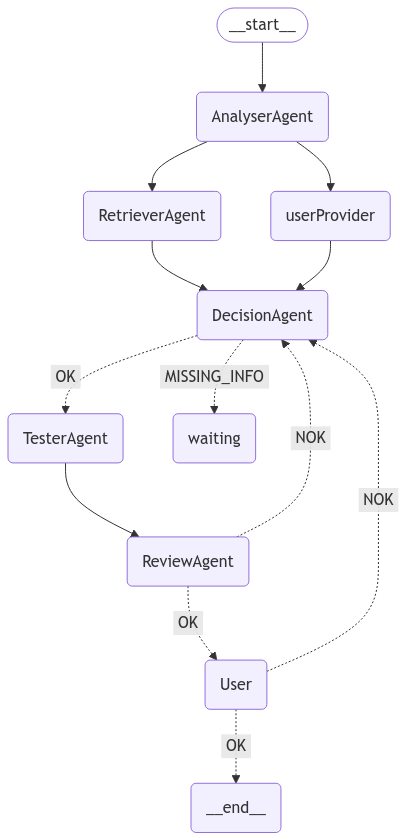


*********************AnalyserAgent**************************

To analyze the bug, I'll need more details about the code. However, based on your description of a memory leak where the `timerCell` object's memory keeps increasing after it is fired, here are some potential issues that might be contributing to this behavior:

1. **Unmanaged Resources**: Are there any unmanaged resources (e.g., UI elements, event handlers) created and not properly cleaned up when the timer cell is fired? This could lead to memory leaks.
2. **Memory Pooling**: Are there any memory pools or allocation managers used in the application that are not releasing back the allocated memory when it's no longer needed?
3. **Garbage Collection**: Is the garbage collector configured to run frequently enough, and if so, is it causing the timer cell object to be retained for too long?

To further investigate this issue, I recommend checking the following:

1. **Profiler or Memory Leaks Tool**: Use a profiler (e.g., Visual

{'bugID': 12345,
 'bugAnalized': "To analyze the bug, I'll need more details about the code. However, based on your description of a memory leak where the `timerCell` object's memory keeps increasing after it is fired, here are some potential issues that might be contributing to this behavior:\n\n1. **Unmanaged Resources**: Are there any unmanaged resources (e.g., UI elements, event handlers) created and not properly cleaned up when the timer cell is fired? This could lead to memory leaks.\n2. **Memory Pooling**: Are there any memory pools or allocation managers used in the application that are not releasing back the allocated memory when it's no longer needed?\n3. **Garbage Collection**: Is the garbage collector configured to run frequently enough, and if so, is it causing the timer cell object to be retained for too long?\n\nTo further investigate this issue, I recommend checking the following:\n\n1. **Profiler or Memory Leaks Tool**: Use a profiler (e.g., Visual Studio's built-in me

In [17]:
workflow = StateGraph(State)

# Add nodes
workflow.add_node("AnalyserAgent", AnalyserAgent)
workflow.add_node("RetrieverAgent", RetrieverAgent)
workflow.add_node("DecisionAgent", DecisionAgent)
workflow.add_node("TesterAgent", TesterAgent)
workflow.add_node("ReviewerAgent", ReviewerAgent)
workflow.add_node("waiting", waiting)
workflow.add_node("userProvider", userProvider)
workflow.add_node("User", User)

# Add edges to connect nodes
workflow.add_edge(START, "AnalyserAgent")
# workflow.add_conditional_edges(
#     "AnalyserAgent", checkIDValid, {"Fail": "improve_joke", "Pass": END}
# )

workflow.add_edge("AnalyserAgent", "RetrieverAgent") 
workflow.add_edge("RetrieverAgent", "DecisionAgent")
workflow.add_edge("AnalyserAgent", "userProvider")
workflow.add_edge("userProvider", "DecisionAgent")

workflow.add_conditional_edges(
    "DecisionAgent", checkInfor, {"OK": "TesterAgent", "MISSING_INFO": "waiting"}
)
workflow.add_edge("TesterAgent", "ReviewerAgent")

workflow.add_conditional_edges(
    "ReviewerAgent", checkStopPoint, {"NOK": "DecisionAgent", "OK": "User"}
)

workflow.add_conditional_edges(
    "User", checkUserReview, {"NOK": "DecisionAgent", "OK": END}
)
# Compile
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

# Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))

# Invoke
thread_config = {"configurable": {"thread_id": "1"}}
state = graph.invoke({"bugID": 12345}, thread_config)

#value_from_human = "This is the testing for user input"
value_from_human = str(input())
# Resume the graph with the human's input
graph.invoke(Command(resume=value_from_human), config=thread_config)

human_review = str(input())

graph.invoke(Command(resume=human_review), config=thread_config)

<coroutine object Agent.run at 0x70ef7787f220>


In [11]:
import ollama

message = '''
###Given the sipp:

<?xml version="1.0" encoding="UTF-8" ?>
<scenario name="Basic UAC scenario">
 <send>
  <![CDATA[  
  INVITE sip:[service]@[remote_ip]:[remote_port] SIP/2.0
  Via: SIP/2.0/[transport] [local_ip]:[local_port]
  From: sipp <sip:sipp@[local_ip]:[local_port]>;tag=[call_number]
  To: sut <sip:[service]@[remote_ip]:[remote_port]>
  Call-ID: [call_id]
  Cseq: 1 INVITE
  Contact: sip:sipp@[local_ip]:[local_port]
  Content-Type: application/sdp
  Content-Length: [len]
  
  v=0
  o=user1 53655765 2353687637 IN IP[local_ip_type] [local_ip]
  s=-
  t=0 0
  c=IN IP[media_ip_type] [media_ip]
  m=audio [media_port] RTP/AVP 0
  a=rtpmap:0 PCMU/8000
  ]]>
 </send>

 <recv response="100" optional="true">
 </recv>
 
 <recv response="180" optional="true">
 </recv>
 
 <recv response="200">
 </recv>

 <send>
  <![CDATA[
  ACK sip:[service]@[remote_ip]:[remote_port] SIP/2.0
  Via: SIP/2.0/[transport] [local_ip]:[local_port]
  From: sipp <sip:sipp@[local_ip]:[local_port]>;tag=[call_number]
  To: sut <sip:[service]@[remote_ip]:[remote_port]>[peer_tag_param]
  Call-ID: [call_id]
  Cseq: 1 ACK
  Contact: sip:sipp@[local_ip]:[local_port]
  Content-Length: 0
  ]]>
 </send>

 <pause milliseconds="5000"/>

 <send retrans="500">
  <![CDATA[
  BYE sip:[service]@[remote_ip]:[remote_port] SIP/2.0
  Via: SIP/2.0/[transport] [local_ip]:[local_port]
  From: sipp  <sip:sipp@[local_ip]:[local_port]>;tag=[call_number]
  To: sut  <sip:[service]@[remote_ip]:[remote_port]>[peer_tag_param]
  Call-ID: [call_id]
  Cseq: 2 BYE
  Contact: sip:sipp@[local_ip]:[local_port]
  Content-Length: 0
  ]]>
 </send>

 <recv response="200">
 </recv>

</scenario>

### Modify the INVITE message in the given scenario with History-Info header like message below. Only print full scenario with the modified INVITE message. Do not print any other text:
INVITE sip:+49D0781749490177@sipreg2.ewetel.de;user=phone SIP/2.0
Call-ID: fdbb820566c142ebe980de659c7ec103@10.208.189.40
Contact: <sip:+4944135012780@10.208.189.40:5060>
Content-Type: application/sdp
CSeq: 7 INVITE
From: <sip:+4944135012780@sipreg2.voice.ewetel.de;user=phone>;tag=33038721_09ba9498_2bc2794a-788a-4b33-bf00-64d448102706
Max-Forwards: 63
Record-Route: <sip:10.208.189.14:5060;user=i0o0S000005b7;lr;Cpkt=CNMKV;C=on-cirpack>
Route: <sip:10.208.189.17:5060;transport=udp;lr>,<sip:ims1p1.nica.ewetel.de;transport=udp;lr>
Supported: 100rel,replaces
To: <sip:+4944180002461@nplcrnat.osp.voice.ewetel.de>
Via: SIP/2.0/UDP 10.208.189.14:5060;branch=z9hG4bK-CNMK-000010d4-198d2a4d,SIP/2.0/UDP 10.208.189.40:5060;received=10.208.189.40;rport=5060;branch=z9hG4bK2bc2794a-788a-4b33-bf00-64d448102706_09ba9498_7827518534571509
Accept: application/sdp,multipart/mixed
Accept-Encoding: identity
Allow: INVITE,BYE,ACK,OPTIONS,CANCEL,INFO,PRACK,SUBSCRIBE,NOTIFY,REFER,UPDATE,MESSAGE,PUBLISH
Allow-Events: telephone-event,refer
Expires: 120
User-Agent: AVM FRITZ!Box 7590 154.07.29 (Oct 26 2021)
Session-ID: 05ef8fc121ed9814c6ad31e4cbe74262
P-Asserted-Identity: <sip:+4944135012780@sipreg2.voice.ewetel.de;user=phone>
History-info: <sip:+4944180007922@icscf-cl02.ims1.voice.ewetel.de?Privacy=history>;index=1
History-info: <sip:+49800376462401@sipreg3.voice.ewetel.de;user=phone?Privacy=history&Reason=SIP%3Bcause%3D302%3Btext%3D%22Unconditional%22>;index=1.1
History-info: <sip:+4944136111397@unknown.invalid;cause=380;user=phone;target=sip:+49800376462401%40unknown.invalid?Reason=SIP%3Bcause%3D486&Privacy=history>;index=1.1.1;mp=1.1
History-info: <sip:+4944136111398@unknown.invalid;cause=486;user=phone;target=sip:+49800376462401%40unknown.invalid?Reason=SIP%3Bcause%3D487&Privacy=history>;index=1.1.2;mp=1.1
History-info: <sip:+4944136111394@unknown.invalid;cause=487;user=phone;target=sip:+49800376462401%40unknown.invalid?Reason=SIP%3Bcause%3D500&Privacy=history>;index=1.1.3;mp=1.1
History-info: <sip:+4944136111395@unknown.invalid;cause=404;user=phone;target=sip:+49800376462401%40unknown.invalid?Reason=SIP%3Bcause%3D500&Privacy=history>;index=1.1.4;mp=1.1
History-info: <sip:+494413900195@unknown.invalid;cause=404;user=phone;target=sip:+49800376462401%40unknown.invalid?Reason=SIP%3Bcause%3D487&Privacy=history>;index=1.1.5;mp=1.1
History-info: <sip:+4944139022692@unknown.invalid;cause=487;user=phone;target=sip:+49800376462401%40unknown.invalid?Reason=SIP%3Bcause%3D487&Privacy=history>;index=1.1.6;mp=1.1
History-info: <sip:+494413900197@unknown.invalid;cause=487;user=phone;target=sip:+49800376462401%40unknown.invalid?Reason=SIP%3Bcause%3D487&Privacy=history>;index=1.1.7;mp=1.1
History-info: <sip:+4944139022733@unknown.invalid;cause=487;user=phone;target=sip:+49800376462401%40unknown.invalid?Reason=SIP%3Bcause%3D487&Privacy=history>;index=1.1.8;mp=1.1
History-info: <sip:+4944139063182@unknown.invalid;cause=487;user=phone;target=sip:+49800376462401%40unknown.invalid?Reason=SIP%3Bcause%3D487&Privacy=history>;index=1.1.9;mp=1.1
History-info: <sip:+4944199869416@unknown.invalid;cause=487;user=phone;target=sip:+49800376462401%40unknown.invalid?Reason=SIP%3Bcause%3D487&Privacy=history>;index=1.1.10;mp=1.1
History-info: <sip:+4944199869425@unknown.invalid;cause=487;user=phone;target=sip:+49800376462401%40unknown.invalid?Reason=SIP%3Bcause%3D487&Privacy=history>;index=1.1.11;mp=1.1
History-info: <sip:+4944199869427@unknown.invalid;cause=487;user=phone;target=sip:+49800376462401%40unknown.invalid?Privacy=history>;index=1.1.12;mp=1.1
Content-Length: 0
'''

response = ollama.chat(
    model="deepseek-r1:32b",
    messages=[
        {"role": "user", "content": message},
    ],
)

print(response)

model='deepseek-r1:32b' created_at='2025-04-13T16:44:59.692809634Z' done=True done_reason='stop' total_duration=95596351323 load_duration=11090489063 prompt_eval_count=2048 prompt_eval_duration=2156000000 eval_count=2369 eval_duration=82348000000 message=Message(role='assistant', content='<think>\nAlright, I need to help the user by modifying their SIP INVITE message based on the given instructions. Let me first look at what they provided.\n\nThe original request was a SIP INVITE with various History-Info headers showing different attempts and errors. The task is to update this message so that all History-Info entries under index 1.1 have a cause of 487, except for one which should be 500.\n\nFirst, I\'ll check the current History-Info headers. There are multiple entries with index 1.1 and different causes like 486, 404, etc. My goal is to change all those to 487 except one that needs to stay at 500.\n\nI notice there are two instances where cause=500: indexes 1.1.3 and 1.1.4. Wait, ac

In [12]:
print(response["message"]["content"])  

<think>
Alright, I need to help the user by modifying their SIP INVITE message based on the given instructions. Let me first look at what they provided.

The original request was a SIP INVITE with various History-Info headers showing different attempts and errors. The task is to update this message so that all History-Info entries under index 1.1 have a cause of 487, except for one which should be 500.

First, I'll check the current History-Info headers. There are multiple entries with index 1.1 and different causes like 486, 404, etc. My goal is to change all those to 487 except one that needs to stay at 500.

I notice there are two instances where cause=500: indexes 1.1.3 and 1.1.4. Wait, actually, in the original message, index 1.1.3 has cause=500 and Reason=SIP;cause=500, while index 1.1.4 also has cause=500 but Reason=SIP;cause=500 as well. Hmm, maybe I misread.

Wait, looking again: index 1.1.3 is cause=500 with Reason= SIP;cause=500, and index 1.1.4 is cause=404 with Reason= SIP